In [1]:
import numpy as np
import cv2
from covidxpert import load_image, perspective_correction
from covidxpert.utils import normalize_image
from glob import glob
import matplotlib.pyplot as plt

In [2]:
def compute_artefacts(image: np.ndarray) -> np.ndarray:
    """Return the artefacts identified in given image.

    Parameters
    -----------------------------
    image: np.ndarray,
        The image from where to extract the artefacts.

    Returns
    -----------------------------
    Boolean mask with the artefacts identified.
    """
    result = cv2.threshold(
        image,
        thresh=np.median(image),
        maxval=255,
        type=cv2.THRESH_BINARY
    )[1]
    _, output, stats, _ = cv2.connectedComponentsWithStats(result, connectivity=8)
    sizes = stats[1:, -1]
    area = np.prod(result.shape)
    artefacts = np.zeros(result.shape, dtype=bool)

    for i, size in enumerate(sizes):
        if size < area/400 and size>10:
            artefacts |= output == i+1

    kernel = np.ones((10, 10), np.uint8)

    artefacts = cv2.dilate(artefacts.astype(np.uint8), kernel)
    artefacts = cv2.morphologyEx(artefacts, cv2.MORPH_CLOSE, kernel=np.ones((3,3)), iterations=10)
    
    return artefacts.astype(bool)

In [3]:
def remove_artefacts(image: np.ndarray) -> np.ndarray:
    """Return image without identified artefacts.

    Parameters
    -----------------------------
    image: np.ndarray,
        The image from where to extract the artefacts.

    Returns
    -----------------------------
    Image without the identified artefacts.
    """
    artefacts = normalize_image(compute_artefacts(image))
    backtorgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    cleared_image = cv2.inpaint(backtorgb,artefacts,11,cv2.INPAINT_TELEA)
    return cv2.cvtColor(cleared_image, cv2.COLOR_RGB2GRAY)

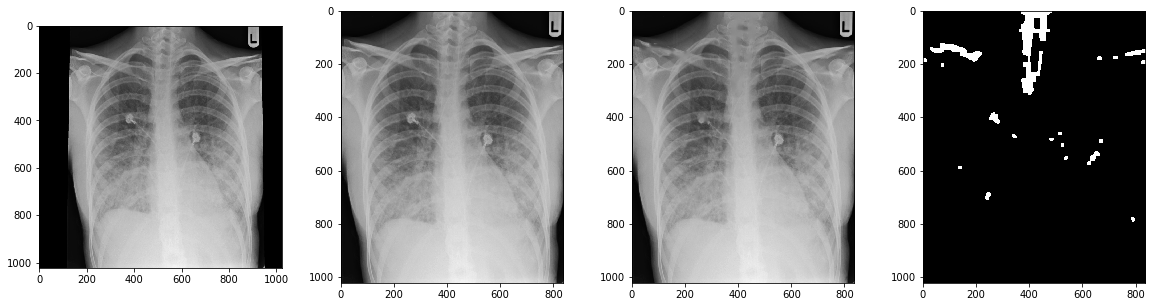

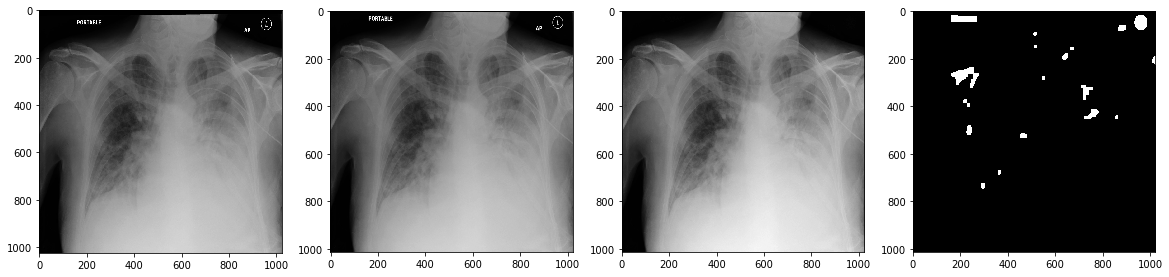

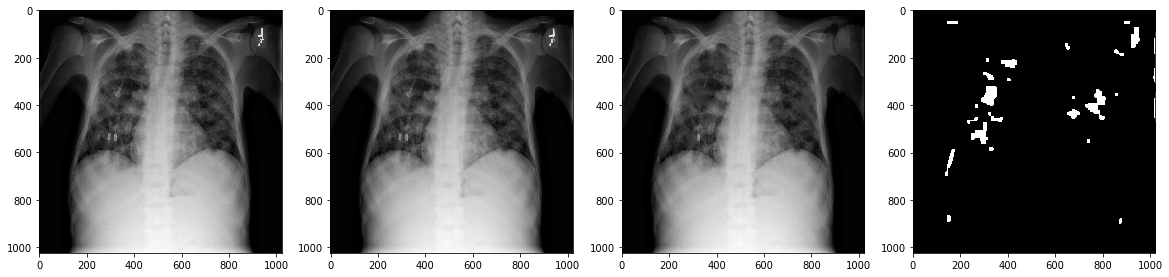

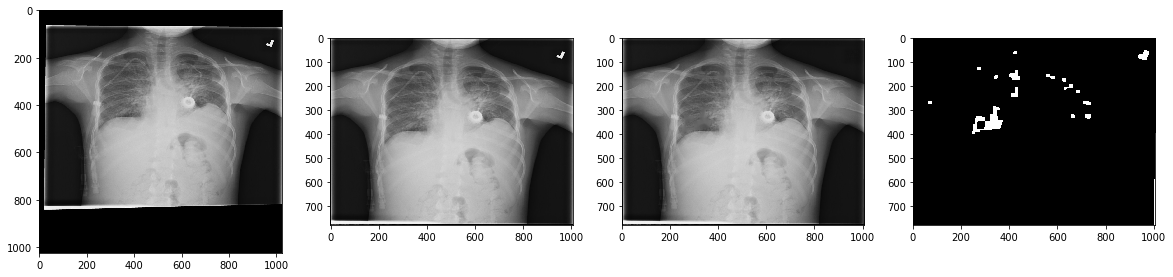

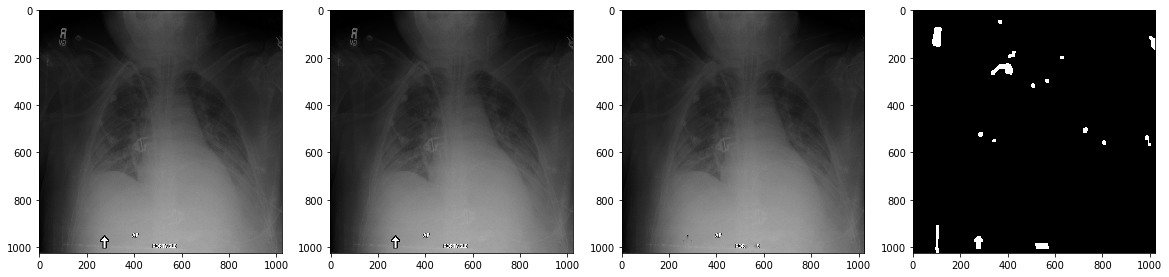

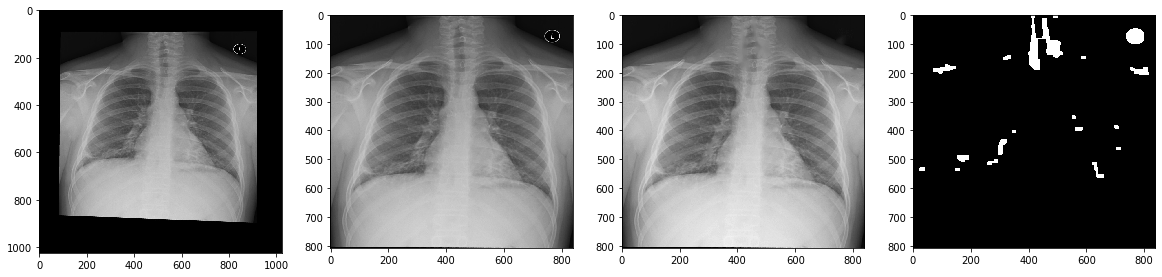

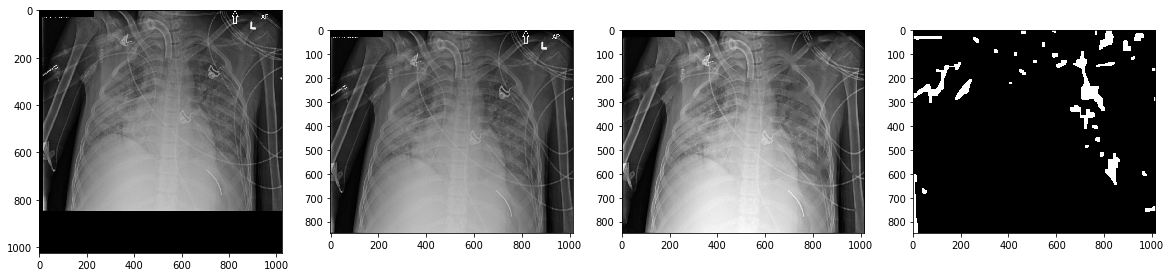

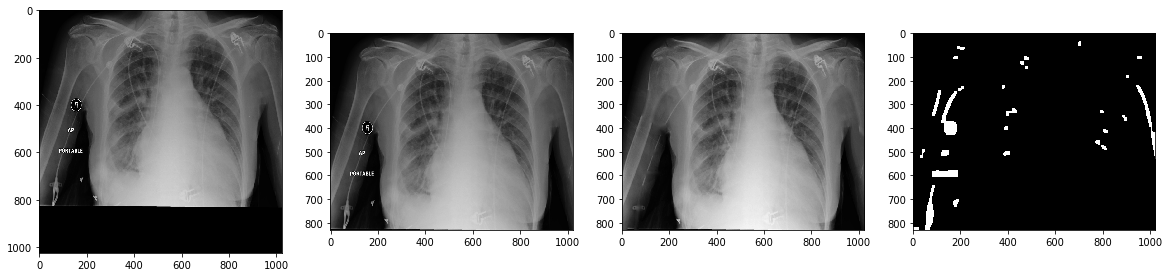

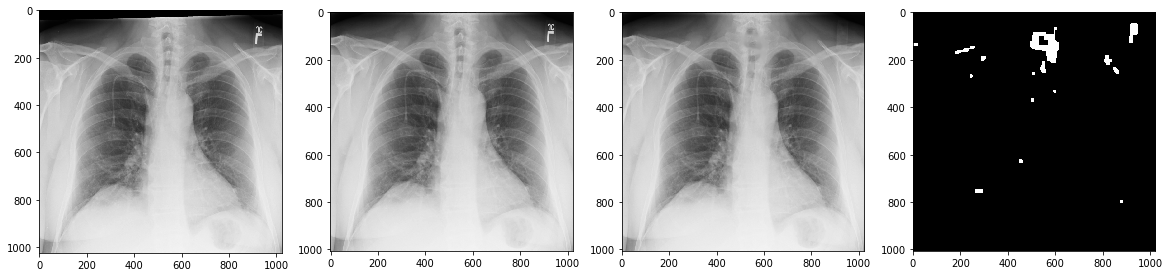

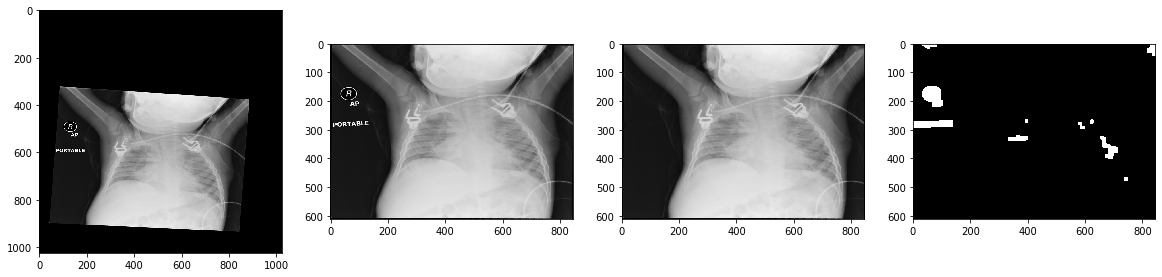

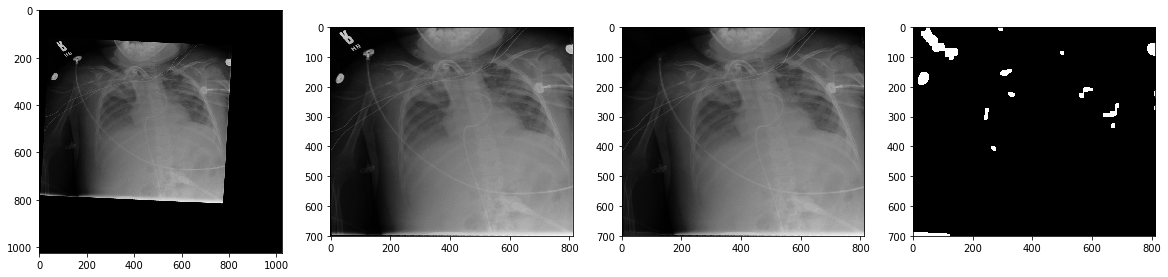

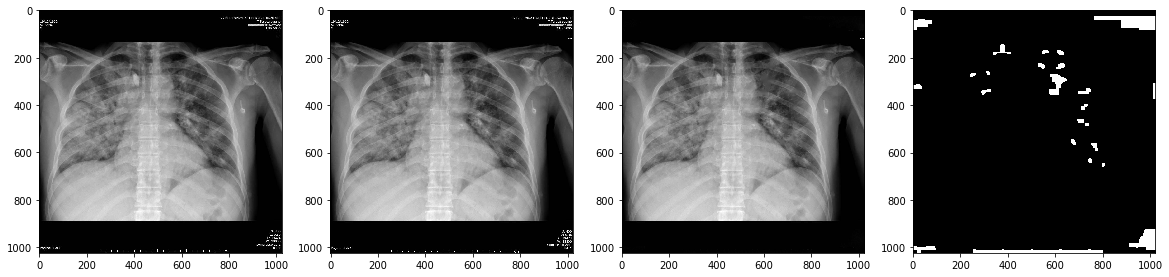

In [4]:
for path in glob("tests/test_images/*.jpg"):
    original = load_image(path)
    corrected = perspective_correction(original)
    artefacts = compute_artefacts(corrected)
    cleared_image = remove_artefacts(corrected)
    
    fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
    axes[0].imshow(original, cmap="gray")
    axes[1].imshow(corrected, cmap="gray")
    axes[2].imshow(cleared_image, cmap="gray")
    axes[3].imshow(artefacts, cmap="gray")
    plt.show()